#  结构化多格网绘图

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks")

## 使用FacetGrid绘图

如果想在数据集的子集中分别可视化变量的分布或者多个变量之间的关系，可以使用FacetGrid。FacetGrid可以在row、col、hug三个维度上进行绘图。

创建FacetGrid对象时，需要使用一个DataFrame来初始化对象，同时也可以设置列、行以及色调变量。但这些变量应该是分类数据或者离散数据。

relplot()、catplot()以及lmplot()底层也是使用FacetGrid来绘图，并返回FacetGrid对象，以便调用者进行更多的设置。

In [2]:
tips = sns.load_dataset("tips")

初始化FacetGrid对象后，并不会绘制图形，而仅仅得到一个图像以及绘图坐标轴

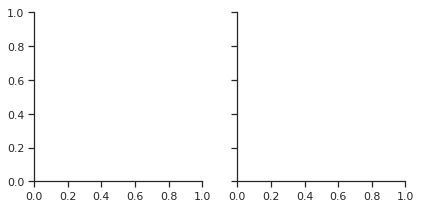

In [3]:
g = sns.FacetGrid(tips, col="time")

通过调用FacetFrid的map方法，可以在其上绘制图形。该方法接受一个绘图函数以及可变数量的参数来绘图。下图是调用map方法绘制直方图的示例。

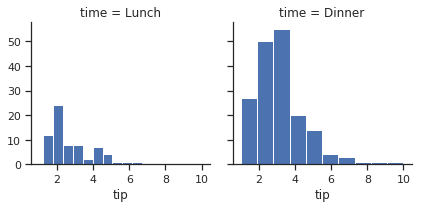

In [4]:
g = sns.FacetGrid(tips, col="time")
g.map(plt.hist, "tip")

map方法会调用绘图函数完成绘图工作同时会自动添加坐标轴注释。如果要绘制多个变量之间的关系，直接传入多个变量即可，map方法也接受关键字参数

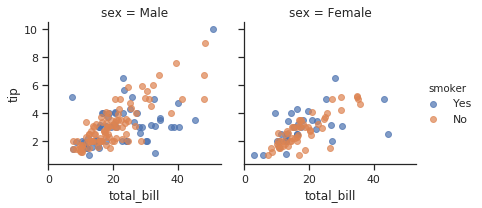

In [5]:
g = sns.FacetGrid(tips, col="sex", hue="smoker")
g.map(plt.scatter, "total_bill", "tip", alpha=.7)
g.add_legend()

也可以在初始化FacetGird对象时传入一些控制样式的参数如margin_titles等。

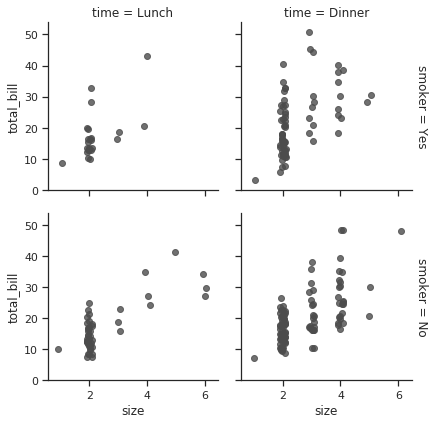

In [6]:
g = sns.FacetGrid(tips, row="smoker", col="time", margin_titles=True)
g.map(sns.regplot, "size", "total_bill", color=".3", fit_reg=False, x_jitter=.1)

每个子图的大小可用通过height和aspect两个参数控制。

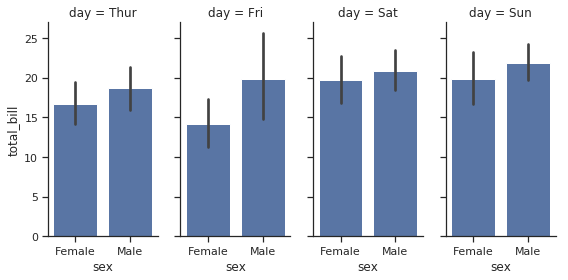

In [11]:
g = sns.FacetGrid(tips, col="day", height=4, aspect=.5)
g.map(sns.barplot, "sex", "total_bill",order=tips.sex.unique())

可以通过row_order或者col_order参数控制子图的顺序。

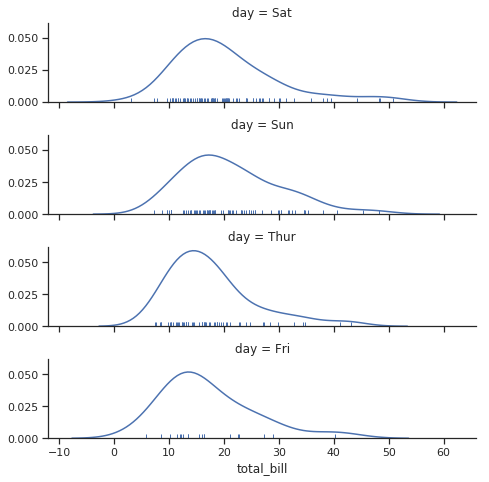

In [13]:
ordered_days = tips.day.value_counts().index
g = sns.FacetGrid(tips, row="day", row_order=ordered_days,height=1.7, aspect=4,)
g.map(sns.distplot, "total_bill", hist=False, rug=True)

可以用任何seaborn支持的调色板初始化FacetGrid对象。也可以使用字典将每个类别值映射成matplot支持的颜色。

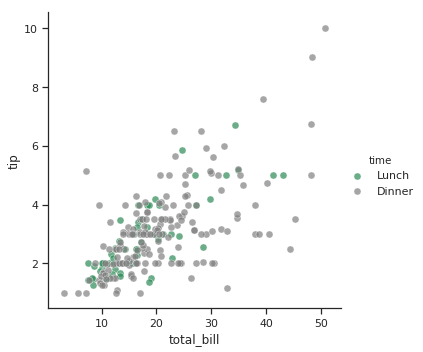

In [24]:
pal = dict(Lunch="seagreen", Dinner="gray")
g = sns.FacetGrid(tips, hue="time", palette=pal, height=5)
g.map(plt.scatter, "total_bill", "tip", s=50, alpha=.7, linewidth=.5, edgecolor="white")
g.add_legend()

可以根据色调语义设置不同的形状。将字典传递给hue_kws参数，其中键是绘图函数关键字参数的名称，值是关键字值的列表，每个级别的色调变量一个。

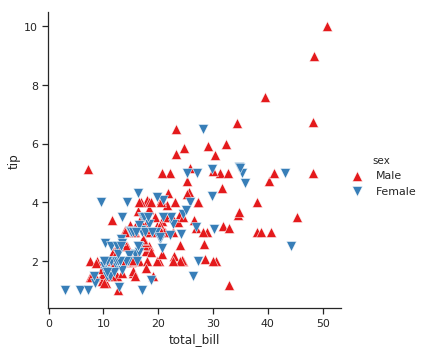

In [14]:
g = sns.FacetGrid(tips, hue="sex", palette="Set1", height=5, hue_kws={"marker": ["^", "v"]})
g.map(plt.scatter, "total_bill", "tip", s=100, linewidth=.5, edgecolor="white")
g.add_legend()

如果一个变量有多个级别，可以沿着列绘制图形。通过设置col_wrap参数实现跨越多行。但此时无法使用row参数。

/disk1/yinwb/softwares/python/miniconda2/envs/py3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


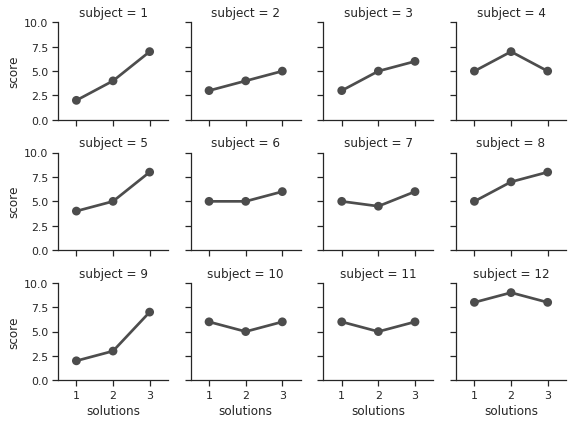

In [15]:
attend = sns.load_dataset("attention").query("subject <= 12")
g = sns.FacetGrid(attend, col="subject", col_wrap=4, height=2, ylim=(0, 10))
g.map(sns.pointplot, "solutions", "score", color=".3", ci=None)

使用FacetGrid.map()（可以多次调用）绘制绘图后，如果需要对图形进行调整，可以通过FacetGrid.set()方法进行设置。也有一些特殊的方法如FacetGrid.set_axis_labels()，该函数用于设置图形外围坐标轴注释，内部图形坐标轴没有任何注释。

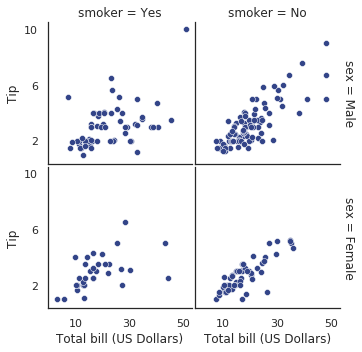

In [16]:
with sns.axes_style("white"):
    g = sns.FacetGrid(tips, row="sex", col="smoker", margin_titles=True, height=2.5)
g.map(plt.scatter, "total_bill", "tip", color="#334488", edgecolor="white", lw=.5);
g.set_axis_labels("Total bill (US Dollars)", "Tip");
g.set(xticks=[10, 30, 50], yticks=[2, 6, 10]);
g.fig.subplots_adjust(wspace=.02, hspace=.02)

甚至可以直接使用matplotlib的Figure和Axes对象进行修改，这些对象作为FacetGrid的fig和ax属性存储在FacetGrid对象中。

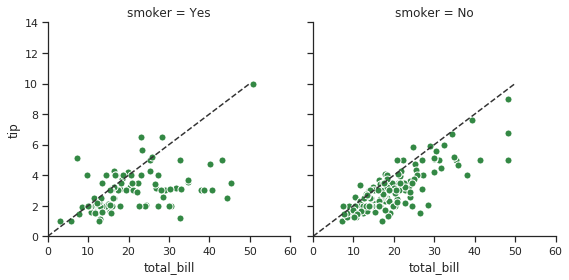

In [17]:
g = sns.FacetGrid(tips, col="smoker", margin_titles=True, height=4)
g.map(plt.scatter, "total_bill", "tip", color="#338844", edgecolor="white", s=50, lw=1)
for ax in g.axes.flat:
    ax.plot((0, 50), (0, .2 * 50), c=".2", ls="--")
g.set(xlim=(0, 60), ylim=(0, 14))

## 使用自定义函数绘图

使用FacetGrid绘图时，并不限于使用matplotlib或者seaborn提供的函数，也可以使用自定义的绘图函数。但是绘图函数必须遵守以下规则：
1. 必须绘制在当前活动的axes上。可以通过plt.gca来获取当前活动的axes。
2. 必须支持使用位置参数获取数据。FacetGrid内部将Series对象的存储的数据按照map方法参数位置顺序传递给绘图函数。
3. 必须支持color和label相关的关键字参数，通常情况下，最简单的方式就是通过**kwargs将字典参数传递给底层函数。

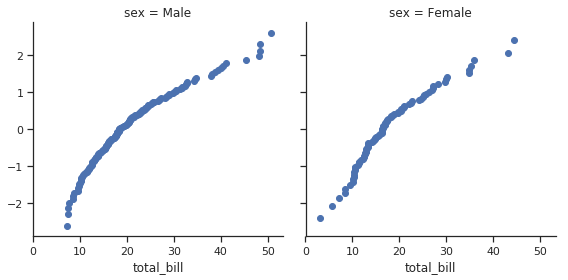

In [18]:
from scipy import stats
def quantile_plot(x, **kwargs):
    qntls, xr = stats.probplot(x, fit=False)
    plt.scatter(xr, qntls, **kwargs)

g = sns.FacetGrid(tips, col="sex", height=4)
g.map(quantile_plot, "total_bill")

如果要绘制二元变量的关系图，自定义函数应该依次接受x、y变量。

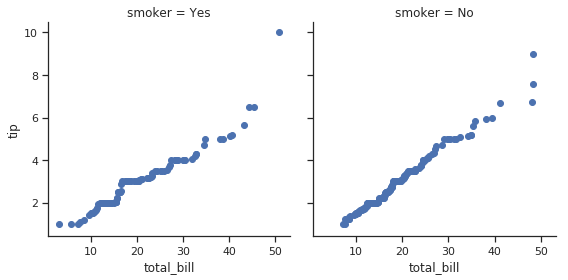

In [19]:
def qqplot(x, y, **kwargs):
    _, xr = stats.probplot(x, fit=False)
    _, yr = stats.probplot(y, fit=False)
    plt.scatter(xr, yr, **kwargs)

g = sns.FacetGrid(tips, col="smoker", height=4)
g.map(qqplot, "total_bill", "tip")

因为plt.scatter支持color和label关键字参数并且会正确使用这些参数，使用色调语义是非常容易的。

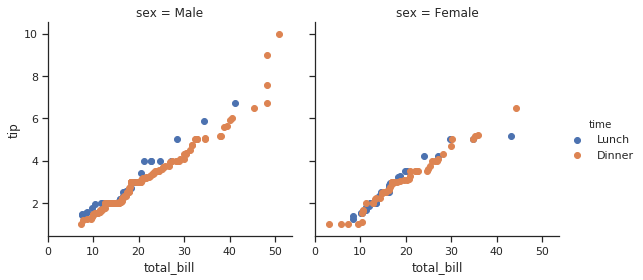

In [20]:
g = sns.FacetGrid(tips, hue="time", col="sex", height=4)
g.map(qqplot, "total_bill", "tip")
g.add_legend()

这种方法也允许我们使用其他美学型式来区分不同色调的级别的变量，这些参数独立于facet变量

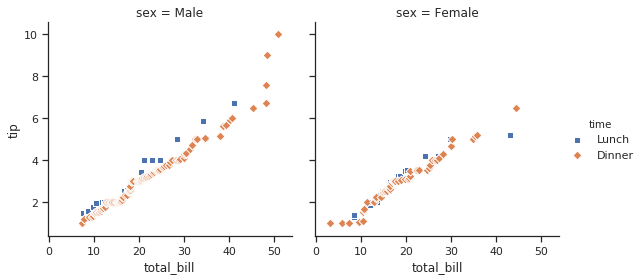

In [28]:
g = sns.FacetGrid(tips, hue="time", col="sex", height=4,hue_kws={"marker": ["s", "D"]})
g.map(qqplot, "total_bill", "tip", s=40, edgecolor="w")
g.add_legend()

如果想要使用color和label关键字参数映射一个不按预期方式工作的函数，则需要显式捕获它们并在自定义函数的逻辑中处理它们。例如，这种方法将允许使用映射plt.hexbin，否则与FacetGridAPI 不兼容。

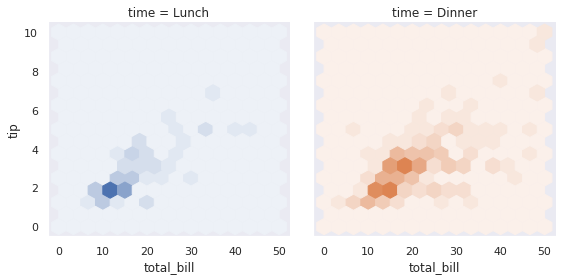

In [22]:
def hexbin(x, y, color, **kwargs):
    cmap = sns.light_palette(color, as_cmap=True)
    plt.hexbin(x, y, gridsize=15, cmap=cmap, **kwargs)

with sns.axes_style("dark"):
    g = sns.FacetGrid(tips, hue="time", col="time", height=4)
g.map(hexbin, "total_bill", "tip", extent=[0, 50, 0, 10])

## 使用PairGrid绘图

FacetGrid中每个字图绘制的是相同的两个变量随着第三个变量变化时的关系，而PairGrid中每个子图绘制多个变量两两之间的关系，每个行和列代表不同的变量。PairGrid的用法与FacetGrid类似，首先创建一个PairGrid对象，然后将绘图函数传递给map方法，依次绘制每个子图。

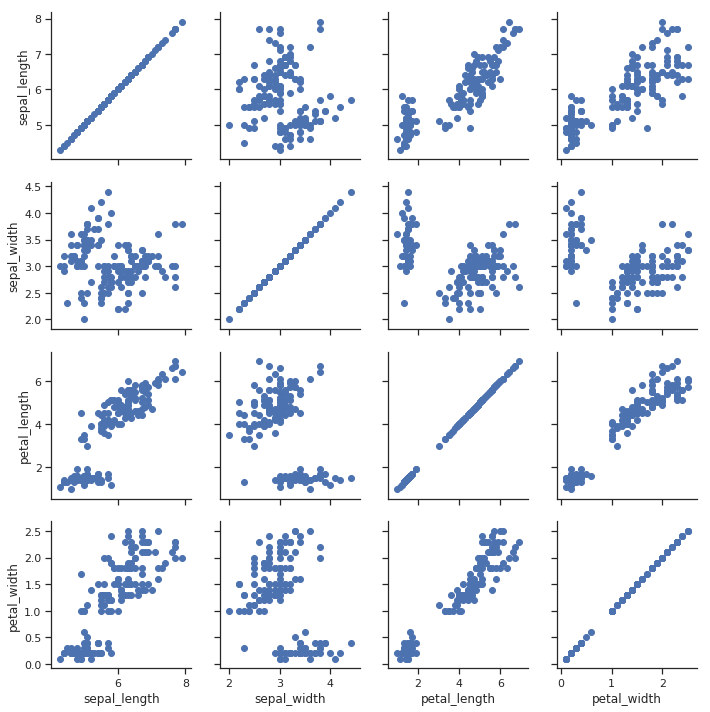

In [29]:
iris = sns.load_dataset("iris")
g = sns.PairGrid(iris)
g.map(plt.scatter)

在对角线上可以使用不同的函数绘图，以显示每列中一元变量的分布。需要注意的是坐标轴上的刻度与其并不对应。

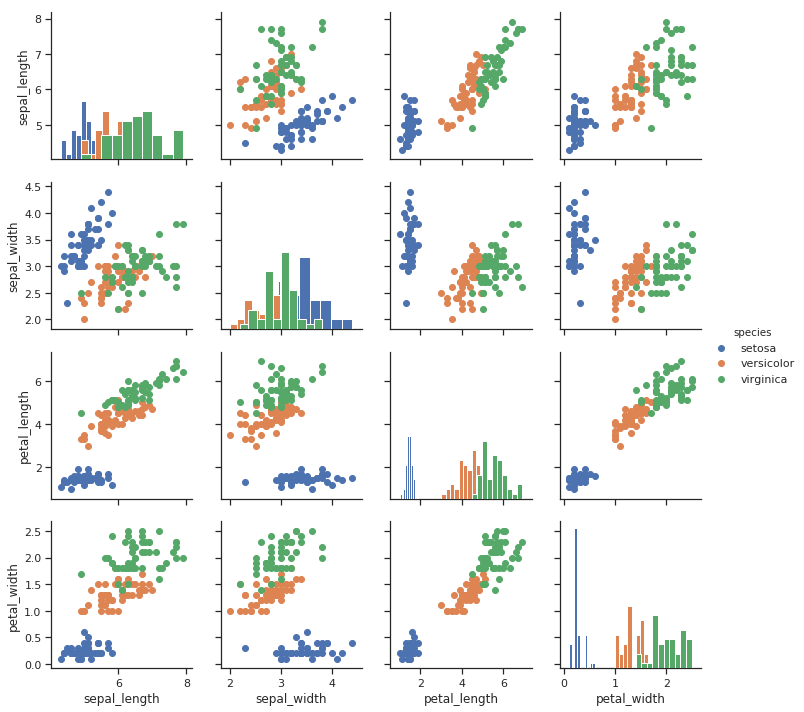

In [30]:
g = sns.PairGrid(iris, hue="species")
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)
g.add_legend();

默认情况下，PairGrid的列与数据集中数值列数相等。但也可以仅绘制其中一部分列。

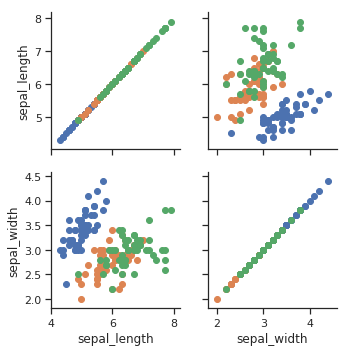

In [31]:
g = sns.PairGrid(iris, vars=["sepal_length", "sepal_width"], hue="species")
g.map(plt.scatter)

可以对上三角和下三角使用不同的绘图函数，从不同的角度强调变量间的关系。

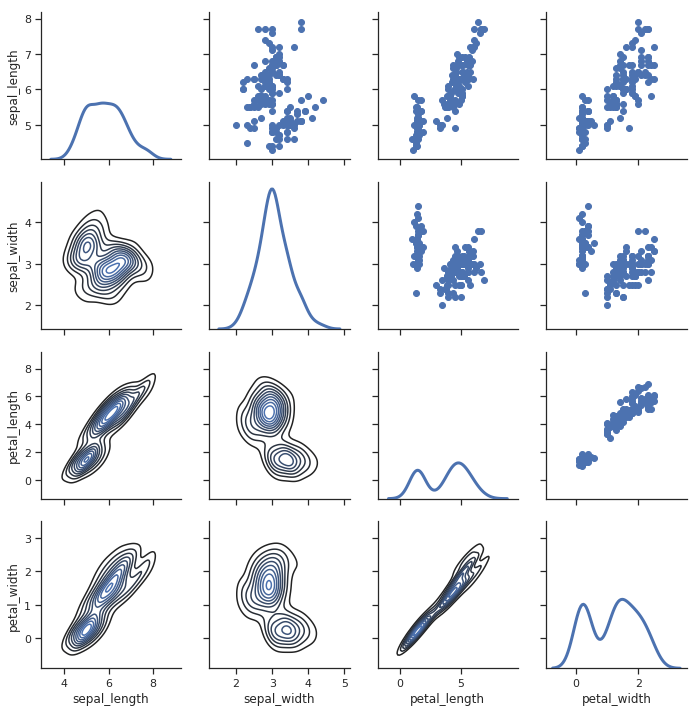

In [32]:
g = sns.PairGrid(iris)
g.map_upper(plt.scatter)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=3, legend=False)